# Introducción

Anteriormente se analizó la viabilidad de diversos algoritmos (DBSCAN, agrupamiento por jerarquía y mezclas gaussianas; se excluyó Kmedias debido a que se desarrolló en clase). Concluyéndose lo siguiente:

- **Agrupamiento por jerarquía**: Sensible a la profundidad de los objetos en los fotogramas. Captura en el mismo grupo a la esponja con una parte de la base sobre la que se encuentra. Además que no es generalizable para todos los fotogramas, debido a que el arreglo de objetos no es constante.
- **Mezclas Gaussianas**: No se consideró apropiado debido a las características *afiladas* de los bordes en las imagenes y que podría no ajustar correctamente en todos los casos, principalmente en los fotogramas donde la prensa está en contacto con la esponja.
- **DBSCAN**: Se eligió este algoritmo debido a que el agrupamiento por densidad podría ser compatible con la heurística humana del reconocimiento de color (por ejemplo amarillos claros con amarillos oscuros en un espectro "amarillo").


--- 

En esta ocasión, respecto a la reducción de dimensionalidad se tiene que recordar el objetivo del análisis:

**Objetivo:** Separar la esponja de la prensa usando algoritmos de agrupamiento (crear máscaras).

Por esta razón se requiere una reducción de dimensionalidad que conserve la interpretabilidad de los datos resultantes. En el reto anterior también se observó que uno de los problemas que presentaba DBSCAN es que no clasificaba correctamente la esponja en zonas con brillo o enfoque de luz; por ello se probó a eliminar características que capturaran las diferencias en el brillo, como el canal $V$. 

**Selección de atributos**: El data set cuenta con los atributos [i,j,H,S,V,R,G,B] que representan la posición y 6 canales de color; 3 canales por 2 espacios de color que codifican a un mismo color. Debido a estos 2 espacios análogos, es viable utilizar este método para eliminar redundancias conservando los valores del espacio original, además de la eliminación manual que se hizo en el reto anterior, siguiendo esta metodología se podría optimizar.

**PCA**: El PCA lleva el conjunto a un espacio de dimensión reducida donde las dimensiones resultantes no son necesariamente interpretables en términos de los canales de colores, esto podría se problemático al momento de querer regresar a crear las máscaras de la esponja y la prensa. Sin embargo, debido a la redundancia de información en los 6 canales de color, quizás la reducción sí lleve a dimensiones que puedan invertirse y conservar la información necesaria.

**Factorización No Negativa**: También podría funcionar, tal como los ejemplos de separación de características físicas de rostros de personas visto en clase. 

# Carga de datos y pre-procesado

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import time as time
import matplotlib.pyplot as plt

In [3]:
from crea_tabla import *
from preprocesamiento import *
import train_step

`NOTA`

Se modificó la función `obtén_tabla_datos` para reescalar la imagen a un porcentaje del alto y ancho original; esto permite aligerar el tiempo de ejecución.

Se creó una serie de funciones de preprocesamiento en `preprocesamiento.py` basado en el resultado de `obtén_tabla_datos` para evitar modificarla más.

In [4]:
# Carcga de datos
conjuntos = [0, 30, 75]
datos, originales = obtén_tabla_datos(conjuntos=conjuntos, rescale = 0.25)

Leyendo numpy...
Organizando renglones...
Creando tabla de datos...
Terminado


In [5]:
# Se ordenan las imágenes originales en un diccionario
images_data = datos.groupby('f')
_, originals = ordenar_datos(images_data, originales)

In [6]:
# Se preprocesan las imágenes seleccionadas
datos = {}
for key,value in originals.items():
    datos[key] = preprocess(value)

# Reducción de dimensionalidad

In [45]:
from sklearn import decomposition
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.base import clone

## PCA

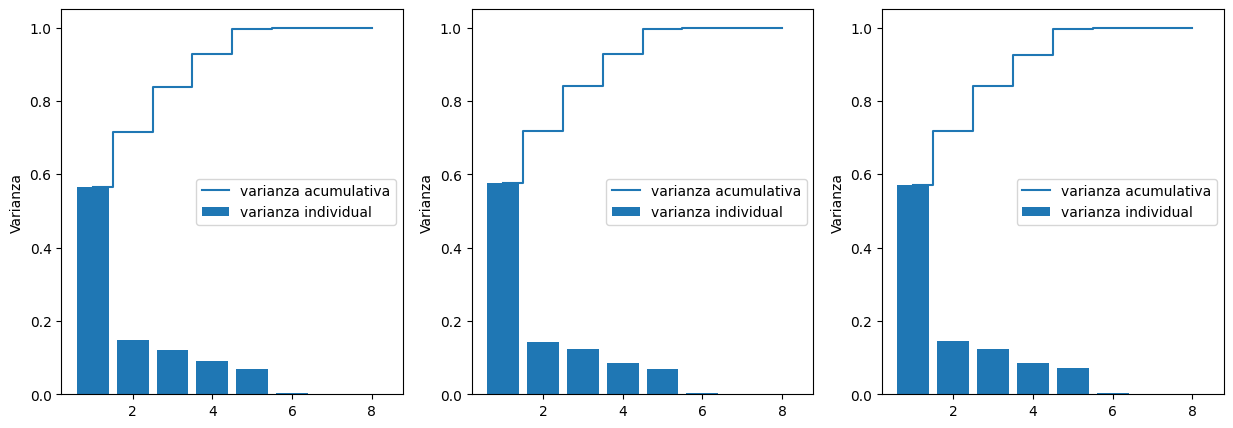

In [8]:
# Varianza acumulada en componentes
fig, axs = plt.subplots(1,3, figsize=(15,5))

for i,data in enumerate(datos.values()):
    varianza_acumulada(data, axs[i])

Según lo anterior, hay practicamente el 100% de varianza acumulada en 5 componentes. Es similar a la selección de atributos que se hizo en el **Reto 1** al eliminarse $V, R, G, B$ y quedarse cólo con 4 atributos. En esa ocasión quizás esto implicaría que falta la información de $V$ (los otros canales tienen información redundante). Quizás al proyectar en 4 o 5 dimensiones se conserve sólo la información que requerimos.

También se puede probar con 3 componentes ya que tiene más del 80% de la varianza acumulada.

### PCA 5 componentes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


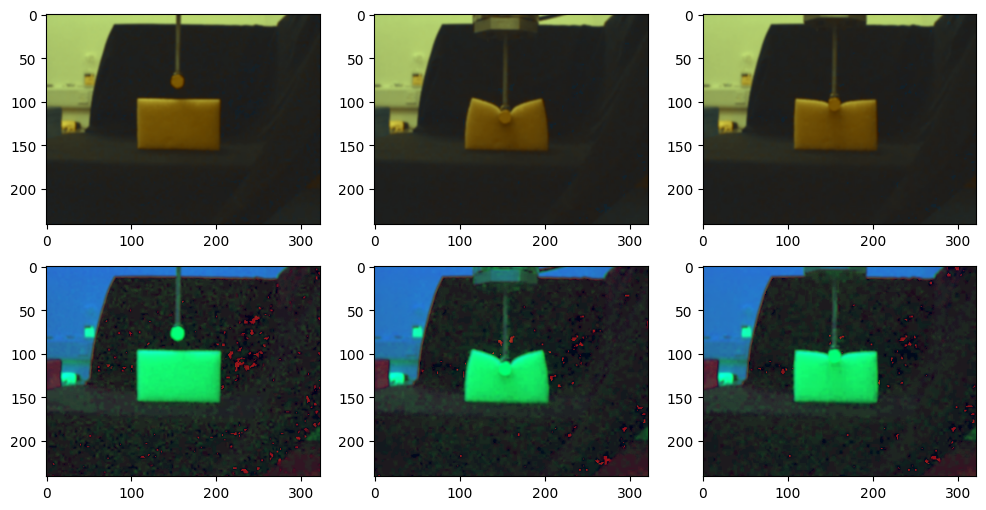

In [61]:
fig, axs = plt.subplots(2,3, figsize=(12,6))

Zs = []
for data,ax in zip(datos.values(), axs.T):
    # Ajuste por PCA
    pca = decomposition.PCA(n_components=5)
    pca.fit(data)
    Z = pca.transform(data)
    Zs.append(Z)

    # Inversa de PCA
    X_inverse_rgb = pca.inverse_transform(Z)[:,[4,3,2]].reshape(originals[0].shape)
    X_inverse_hsv = pca.inverse_transform(Z)[:,[5,6,7]].reshape(originals[0].shape)

    ax[0].imshow(X_inverse_rgb.astype(int), aspect='auto')
    ax[1].imshow(X_inverse_hsv.astype(int), aspect='auto')

A pesar de que se analiza a través de la inversa de PCA, se puede notar que la información no perdida no logra distinguir entre la prensa y la esponja.

Tiempo transcurrido: 8.942s
Tiempo transcurrido: 8.714s
Tiempo transcurrido: 8.130s


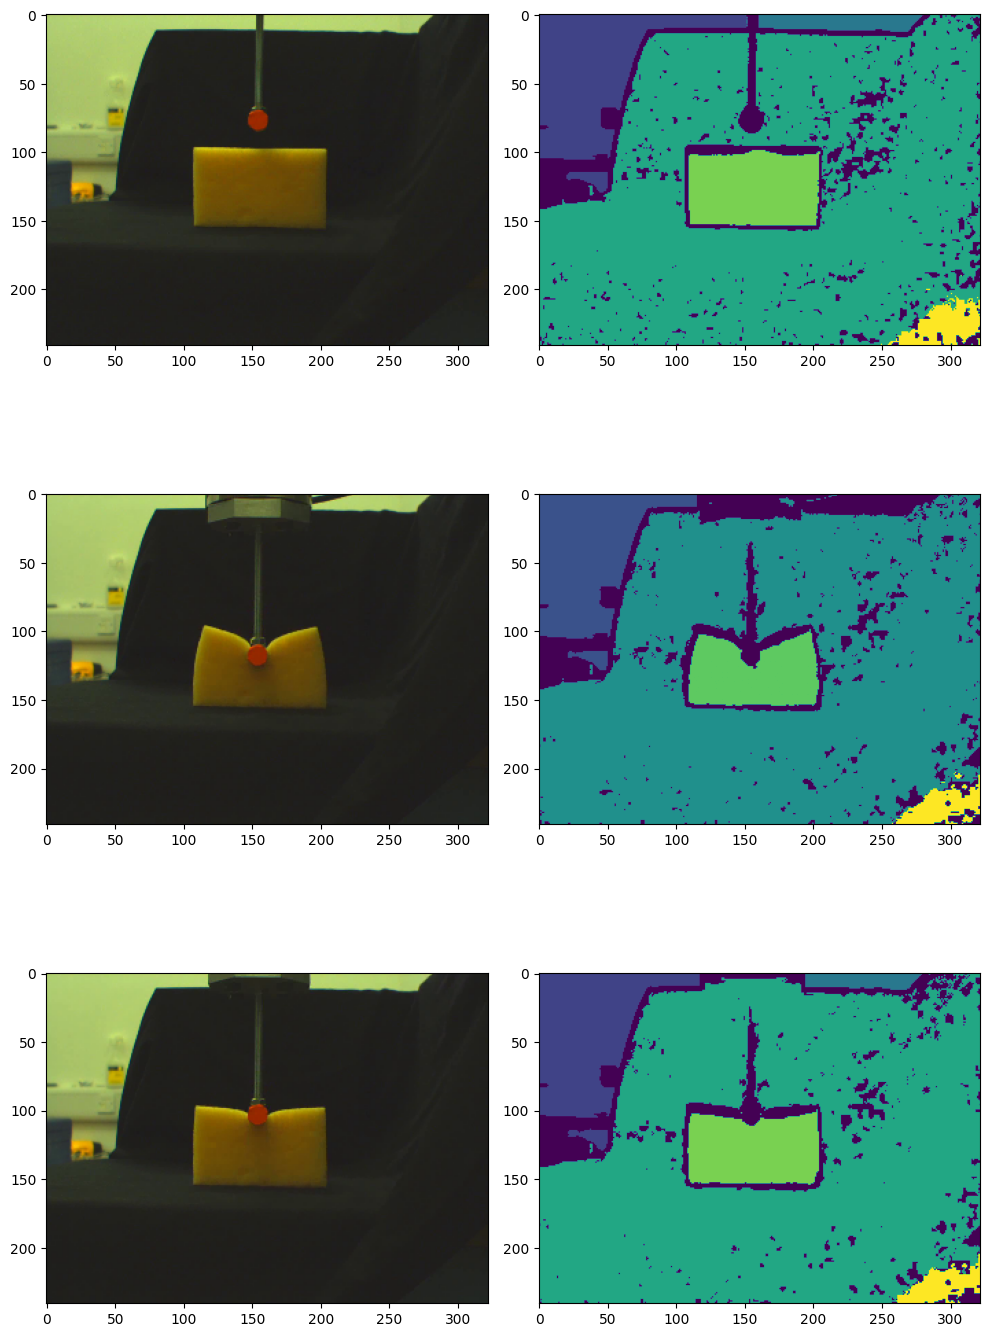

In [62]:
fig, axs = plt.subplots(3,2, figsize = (10,15))

labels = {}
for i, (image_pre, image_real, ax) in enumerate(zip(Zs, originals.values(), axs)): # Pendiente por ordenar código
    image_process = image_pre
    labels[list(datos.keys())[i]] = train_step.dbscan(image_process, image_real, ax)

fig.tight_layout()

In [64]:
for i, (Z,label) in enumerate(zip(Zs,labels.values())):
    print(f"silhouette_score {i}: ", silhouette_score(Z,label))

silhouette_score 0:  0.13514806683640065
silhouette_score 1:  0.13551470648482988
silhouette_score 2:  0.1366538658374246


### PCA 3 componentes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


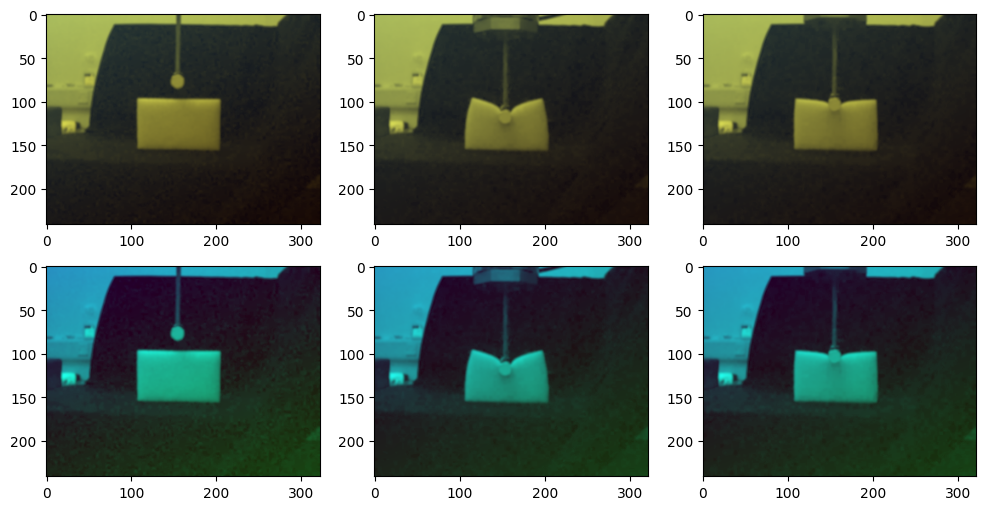

In [46]:
fig, axs = plt.subplots(2,3, figsize=(12,6))

Zs = []
for data,ax in zip(datos.values(), axs.T):
    # Ajuste por PCA
    pca = decomposition.PCA(n_components=3)
    pca.fit(data)
    Z = pca.transform(data)
    Zs.append(Z)

    # Inversa de PCA
    X_inverse_rgb = pca.inverse_transform(Z)[:,[4,3,2]].reshape(originals[0].shape)
    X_inverse_hsv = pca.inverse_transform(Z)[:,[5,6,7]].reshape(originals[0].shape)

    ax[0].imshow(X_inverse_rgb.astype(int), aspect='auto')
    ax[1].imshow(X_inverse_hsv.astype(int), aspect='auto')

En el caso de 3 dimensiones en el espacio transformado, la información perdida es aún mayor.

Tiempo transcurrido: 19.151s
Tiempo transcurrido: 7.253s
Tiempo transcurrido: 7.417s


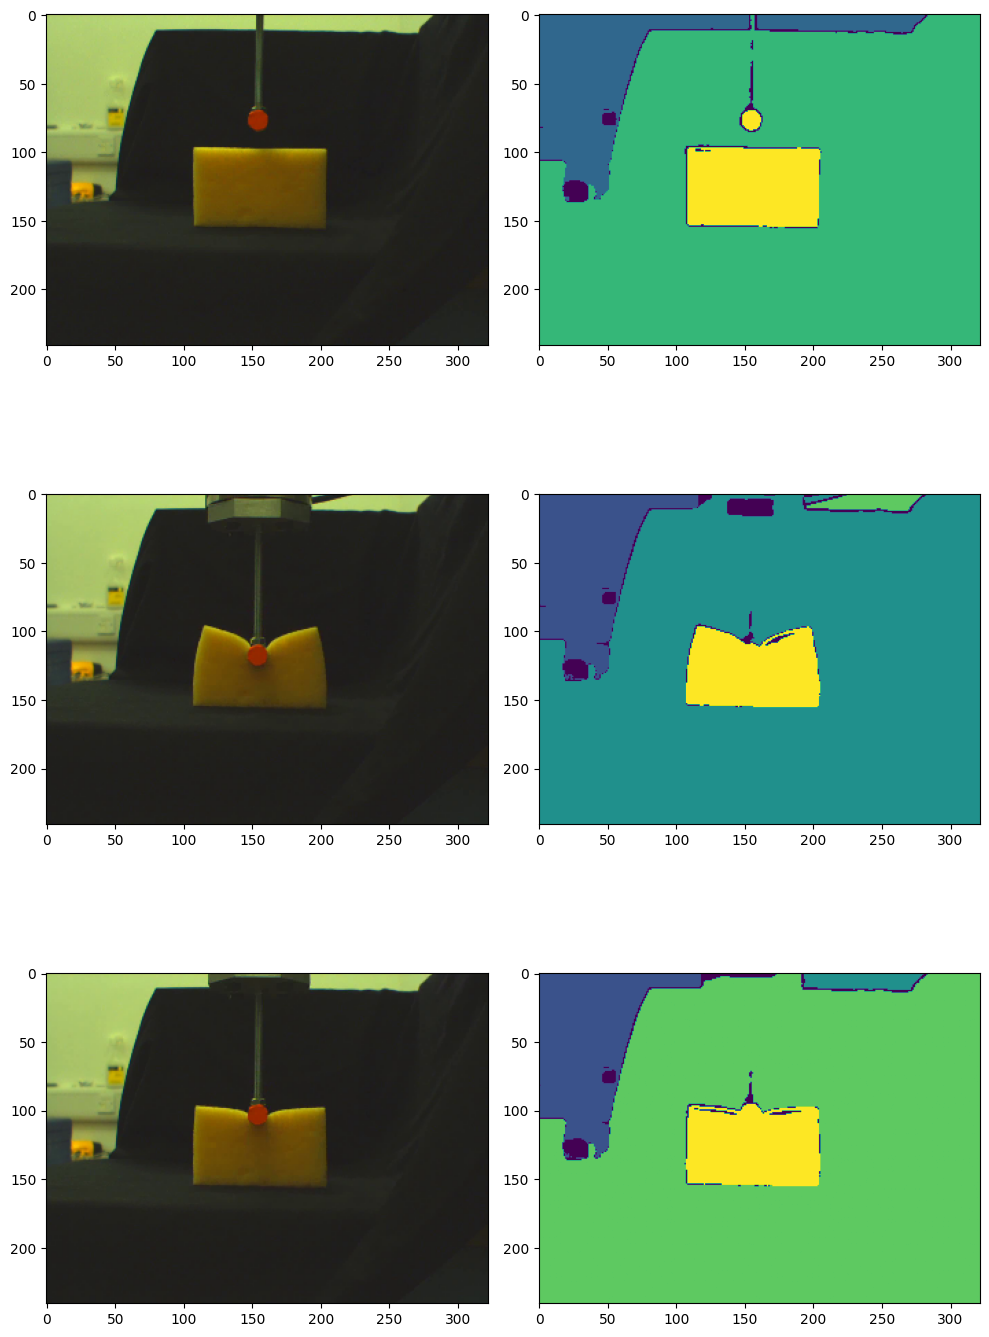

In [47]:
fig, axs = plt.subplots(3,2, figsize = (10,15))

labels = {}
for i, (image_pre, image_real, ax) in enumerate(zip(Zs, originals.values(), axs)): # Pendiente por ordenar código
    image_process = image_pre
    labels[list(datos.keys())[i]] = train_step.dbscan(image_process, image_real, ax)

fig.tight_layout()

In [60]:
for i, (Z,label) in enumerate(zip(Zs,labels.values())):
    print(f"silhouette_score {i}: ", silhouette_score(Z,label))

silhouette_score 0:  0.40514409788105743
silhouette_score 1:  0.38597728763525474
silhouette_score 2:  0.40753549660485305


Si bien con 3 componentes, parece ajustar bastante bien a la esponja, justo como lo observado anteriormente, se usa la misma máscara para la prensa como para la esponja. 
Es consistente con lo que esperabamos; que aproximadamente 3 o 4 dimensiones, eliminarían la redundancia en la información debido a los 2 espacios de colores. Sin embargo, también se pierden diferencias cruciales.

Este resultado es muy parecido al obtenido con K-Medias.

## Selección de atributos

Se tuvo una experiencia en selección de atributos manual (`1. Test procesamiento.ipynb > Preprocesamiento > Filtro Gaussiano + Ignorar Caracteristicas`). Esto se realizó para BSCAN, ya que K-Means daba un resultado en general, mejor, en esta ocasión haremos iteraciones aplicando K-Means que, además, es más rápido por lo que podemos explorar mejor el espacio de combinaciones de características.

In [43]:
# Selección hacia adelante para clustering
def forward_feature_selection(X, max_features, n_clusters):
    n_samples, n_features = X.shape
    selected_features = []
    remaining_features = list(range(n_features))
    best_score = -np.inf
    best_silhouette = -np.inf

    while remaining_features and len(selected_features) < max_features:
        scores = []
        silhouette_scores = []
        for feature in remaining_features:
            # Separar características
            trial_features = selected_features + [feature]
            X_trial = X[:, trial_features]

            # Definir y entrenar K-Means
            kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_trial)
            labels = kmeans.labels_

            # Evaluar las métricas correspondientes
            silhouette = silhouette_score(X_trial, labels)
            silhouette_scores.append(silhouette)

        best_idx = np.argmax(silhouette_scores)
        if silhouette_scores[best_idx] > best_silhouette:
            best_silhouette = silhouette_scores[best_idx]
            # best_score = scores[best_idx]
            selected_features.append(remaining_features.pop(best_idx))
        else:
            break

    return selected_features, best_score

In [44]:
# Datos de entrada
features = datos[0].to_numpy()  # Reemplazar con tus datos reales
n_clusters = 4  # Número de clusters que deseas encontrar
max_features = 4

# Aplicar selección hacia adelante
selected_features, best_score = forward_feature_selection(features, max_features=max_features, n_clusters=n_clusters)
print('Selected features:', selected_features)
print('Best score:', best_score)

# Crear el modelo final de clustering con las características seleccionadas
X_selected = features[:, selected_features]
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_selected)
labels = kmeans.labels_


c:\Users\Jafet Velásquez Luna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Jafet Velásquez Luna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Jafet Velásquez Luna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Jafet Velásquez Luna\AppData\Lo

Selected features: [4]
Best score: -inf


c:\Users\Jafet Velásquez Luna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Se considera una mejor selección de atributos la lograda por las pruebas realizadas en `1. Test preprocesamiento`, sea por que la implementación no logró converger o por que la realizada manualmente descarta atributos basándose en interpretaciones cualitativas sobre la influencia de los atributos descartados.

# Entrenamiento (anterior)

### min_samples = 776 | $\epsilon = 0.4$

Tiempo transcurrido: 4.711s
Tiempo transcurrido: 4.358s
Tiempo transcurrido: 4.610s


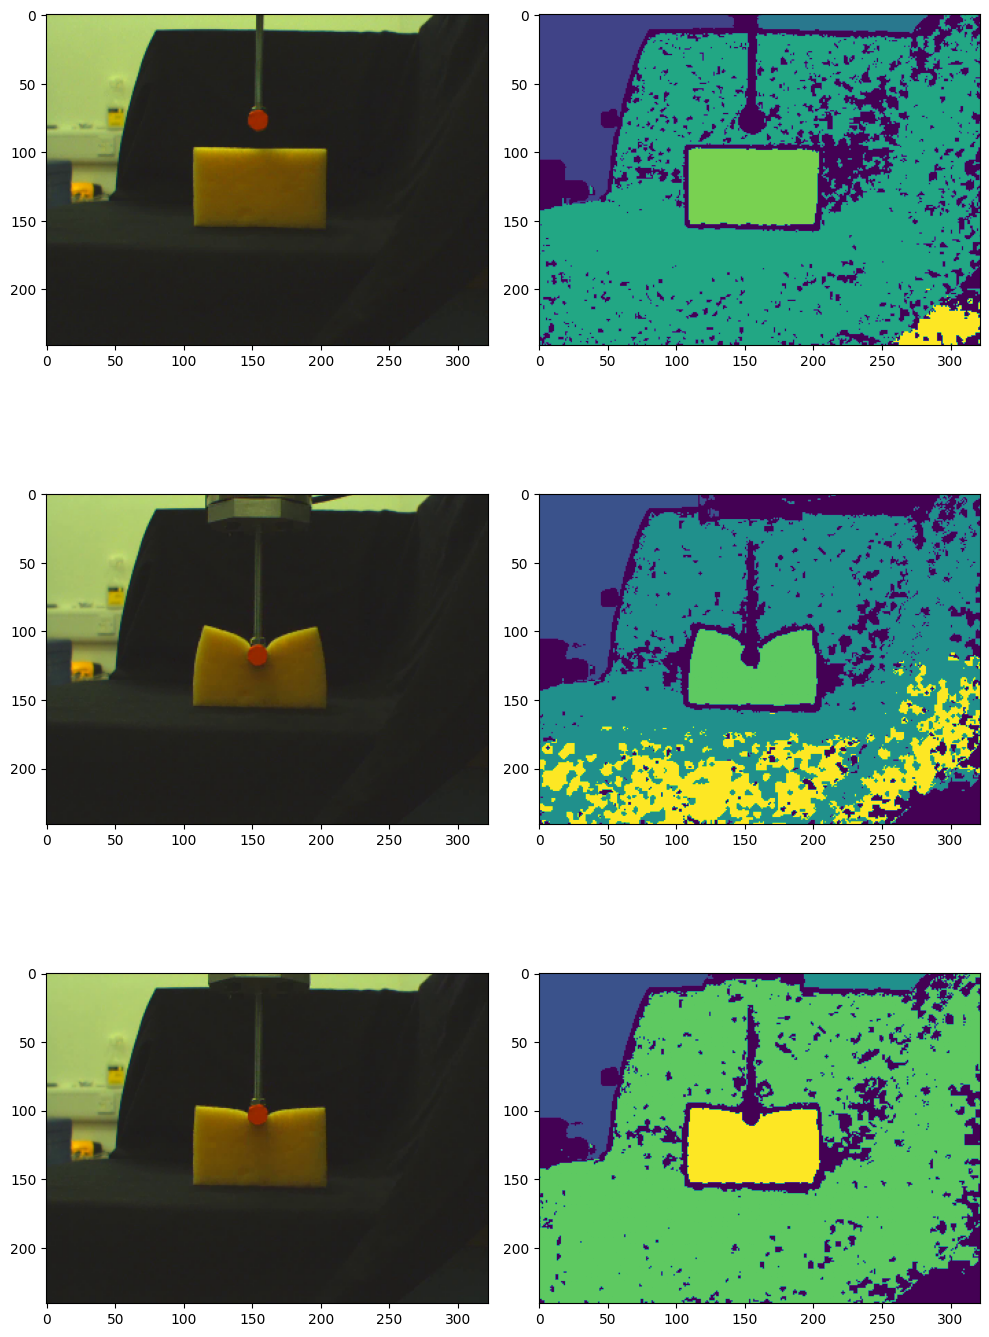

In [33]:
fig, axs = plt.subplots(3,2, figsize = (10,15))

labels = {}
for i, (image_pre, image_real, ax) in enumerate(zip(datos.values(), originals.values(), axs)): # Pendiente por ordenar código
    image_process = image_pre.drop(['V', 'R', 'G', 'B'], axis=1)
    labels[list(datos.keys())[i]] = train_dbscan(image_process, image_real, ax)

fig.tight_layout()

### min_samples = 776 | $\epsilon = 0.5$

Tiempo transcurrido: 6.774s
Tiempo transcurrido: 6.117s
Tiempo transcurrido: 6.065s


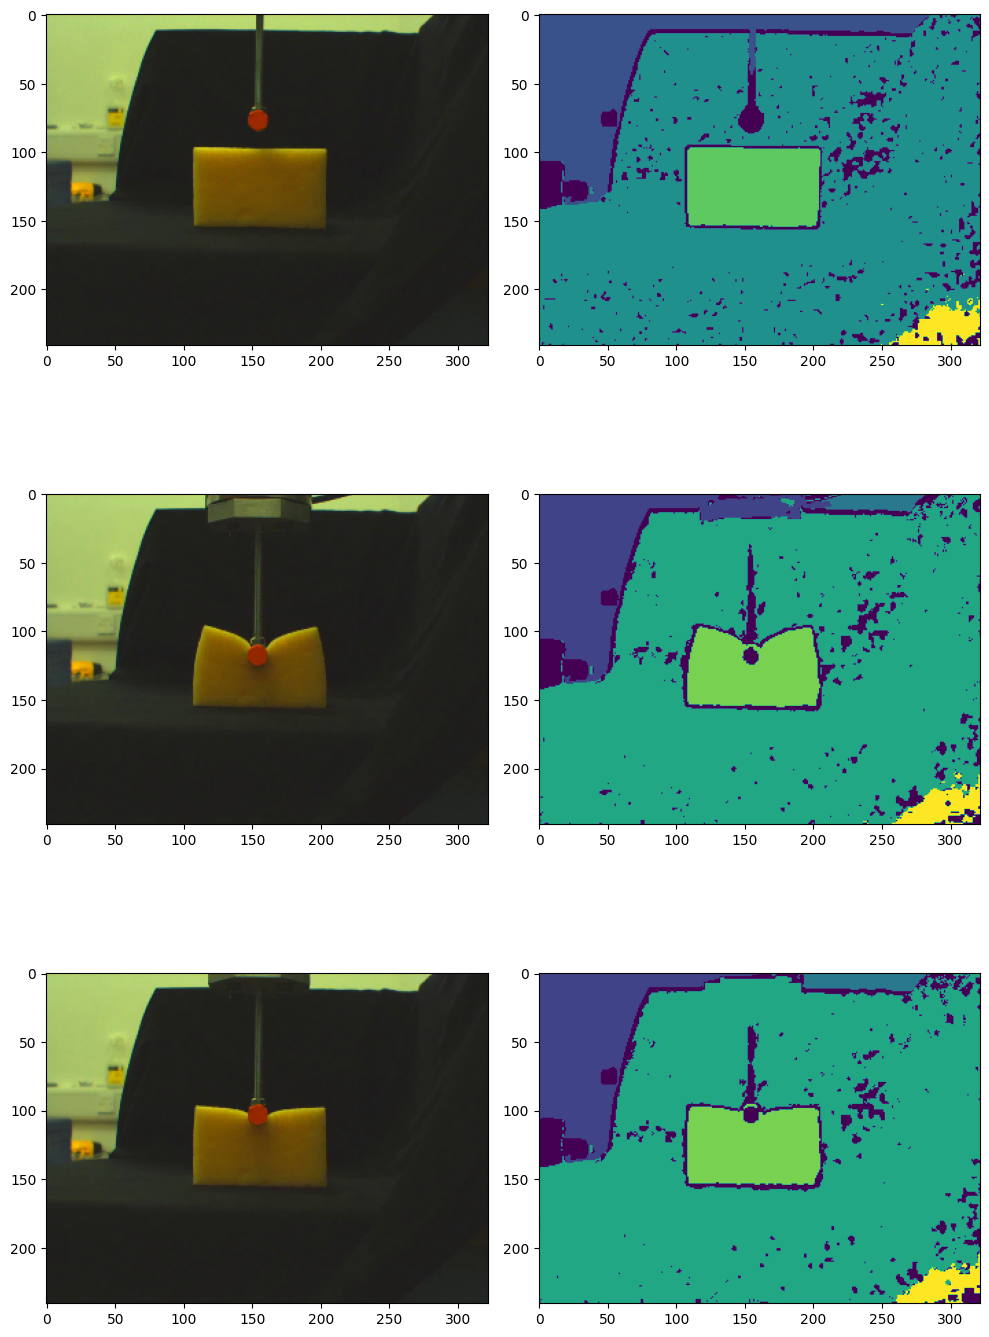

In [25]:
fig, axs = plt.subplots(3,2, figsize = (10,15))

labels = {}
for i, (image_pre, image_real, ax) in enumerate(zip(datos.values(), originals.values(), axs)): # Pendiente por ordenar código
    image_process = image_pre.drop(['V', 'R', 'G', 'B'], axis=1)
    labels[list(datos.keys())[i]] = train_dbscan(image_process, image_real, ax)

fig.tight_layout()

# Evaluación e interpretación (anterior)

### silhouette_score

In [35]:
from sklearn.metrics import silhouette_score

In [36]:
# min_samples = 776 | $\epsilon = 0.4$
for frame_n in labels.keys():
    real_img = originals[frame_n].reshape(-1,3) # Dimensión correcta para el score
    label = labels[frame_n]
    silhouette_avg = silhouette_score(real_img, label)
    print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.014529332004483544
Silhouette Score: -0.12856202124208205
Silhouette Score: 0.44011084289416225


In [35]:
## min_samples = 776 | $\epsilon = 0.5$
for frame_n in labels.keys():
    real_img = originals[frame_n].reshape(-1,3) # Dimensión correcta para el score
    label = labels[frame_n]
    silhouette_avg = silhouette_score(real_img, label)
    print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.191945348189976
Silhouette Score: 0.09194397050077029
Silhouette Score: 0.14817826923901517


La interpretación del `silhouette_score` nos dice que el mejor valor es 1, mientras que el peor es -1; mientras que valores cercanos a 0 indican grupos superpuestos.

En el último caso, encontramos un score medio de $0.144$. Se puede decir que, si bien no hay una pésima cohesión entre los grupos (pues los score logran ser mayores que cero), sí hay problemas de grupos intercalados. Esto puede ser debido al suavizado gaussiano que se realizó en el preprocesamiento, ya que los contornos en las figuras se suavizaron para reducir el ruido.

Se considera que este valor se puede incrementar si se añaden pasos en el preprocesamiento para eliminar totalmente el ruido de las regiones, intentando mantener un equilibrio con la definición de los bordes de los objetos. Por ejmplo, la realización con parámetros min_samples = 776 | $\epsilon = 0.4$ obtuvo un mayor score en el fotograma 75 ya que pudo separar el punto rojo de la prensa, lo cual no pudo hacer el modelo con $\epsilon = 0.5$.

### DBCV (Density-Based Clustering Validation)

Se intentó realizar esta prueba que, según la literatura, es más apropiada para el ruido en los algoritmos basados en densidad, pero requería un alto espacio en memoria.

In [ ]:
#!pip install hdbscan

In [19]:
import hdbscan

In [ ]:
hdbscan.validity.validity_index(originals[0].reshape(-1,3), labels[0])
# Unable to allocate 8.72 GiB for an array with shape (1170287384,) and data type float64